# **Appendix 2**

This section contains the code for training the model and developing the frontend smartwatch application used in this project.


# 8.1 ResNet50 Model training code

In [ ]:
import numpy as np 
import pandas as pd 
import os

import csv

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax, Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add, MaxPool1D,ZeroPadding1D, LSTM
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data ingestion stage

In [ ]:
os.chdir('drive/MyDrive/Major Project/Customized_Dataset/')
path = ''

In [ ]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec


In [ ]:
window_size = 180
count = 10000

classes = ['N', 'S', 'F', 'V', 'Q']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Data preparation stage

In [ ]:
filenames = os.listdir()
records = list()
annotations = list()
filenames.sort()

In [ ]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    else:
        annotations.append(path + filename + file_extension)

# Data preprocessing stage

<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-eb74913cffa6>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-eb74913cffa6>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
<ipython-input-8-eb74913cffa6>:46: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1 and not example_beat_printed:


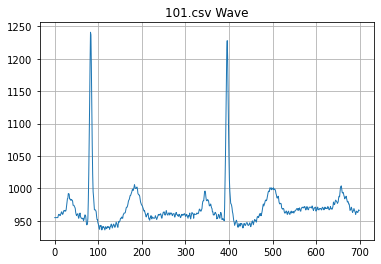

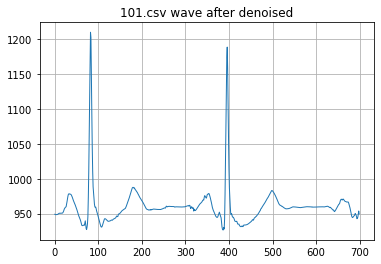

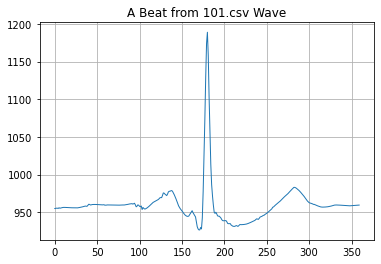

In [ ]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        # Plotting ECG graph for each patient
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    
    if r is 1:
        # Plotting ECG graph for each patient
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        

    # Smoothing ECG graph
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted)) 
            arrhythmia_type = next(splitted) 
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     
                    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

In [ ]:
os.chdir('..')

In [ ]:
X = pd.read_csv('datafile.csv')
y = pd.read_csv('outfile.csv')
print(len(X), len(y))


190959 190959


# Checking for Classes Distribution

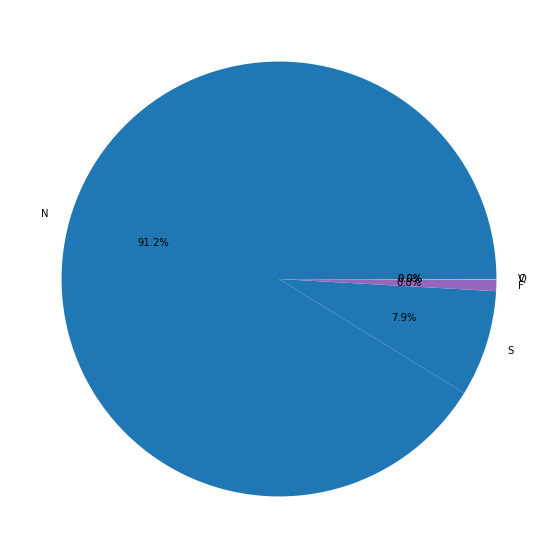

In [ ]:
X_train_df = X.copy()
per_class = X_train_df['360'].value_counts()
# print(per_class)
plt.figure(figsize=(20,10))
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:blue','tab:purple','tab:olive','tab:red'],autopct='%1.1f%%')
p=plt.gcf()
plt.show()

# Solving unbalanced class problem

In [ ]:
df_1=X_train_df[X_train_df['360']==1]
df_2=X_train_df[X_train_df['360']==2]
df_3=X_train_df[X_train_df['360']==3]
df_4=X_train_df[X_train_df['360']==4]

df_0=(X_train_df[X_train_df['360']==0]).sample(n=5000,random_state=42)
df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

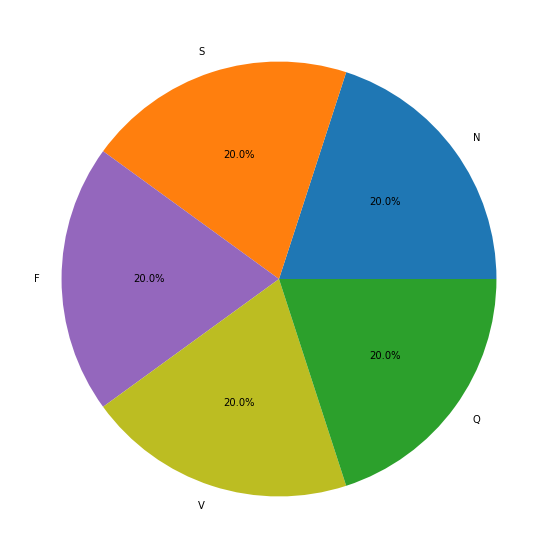

In [ ]:
per_class = X_train_df['360'].value_counts()
# print(per_class)
plt.figure(figsize=(20,10))
plt.pie(per_class, labels=['N', 'S', 'F', 'V', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
plt.show()

# Train Test split

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train['360']
target_test=test['360']
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


# ResNet50 model building

In [ ]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def ResNet50(input_shape = (360,1)):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, activation='relu', strides = 2)(X)
    X = BatchNormalization()(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(5,activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resNet50_model = ResNet50(input_shape = (360,1))

In [ ]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 366, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 180, 64)      512         ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 180, 64)     256         ['conv1d[0][0]']                 
 alization)                                                                                

In [ ]:
resNet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resNet50_model_history = resNet50_model.fit(train_x, train_y, epochs = 20, batch_size = 100, validation_data = (test_x, test_y))

Epoch 1/20
200/200 [==============================] - 87s 176ms/step - loss: 1.4762 - accuracy: 0.7231 - val_loss: 2.2632 - val_accuracy: 0.3538
Epoch 2/20
200/200 [==============================] - 34s 170ms/step - loss: 0.4930 - accuracy: 0.9160 - val_loss: 3.9634 - val_accuracy: 0.4994
Epoch 3/20
200/200 [==============================] - 33s 167ms/step - loss: 0.3902 - accuracy: 0.9441 - val_loss: 0.2662 - val_accuracy: 0.9254
Epoch 4/20
200/200 [==============================] - 33s 164ms/step - loss: 0.1954 - accuracy: 0.9617 - val_loss: 0.1215 - val_accuracy: 0.9624
Epoch 5/20
200/200 [==============================] - 33s 164ms/step - loss: 0.1426 - accuracy: 0.9730 - val_loss: 0.0792 - val_accuracy: 0.9750
Epoch 6/20
200/200 [==============================] - 33s 167ms/step - loss: 0.1121 - accuracy: 0.9754 - val_loss: 0.0877 - val_accuracy: 0.9732
Epoch 7/20
200/200 [==============================] - 33s 165ms/step - loss: 0.0503 - accuracy: 0.9826 - val_loss: 0.0580 - val_ac

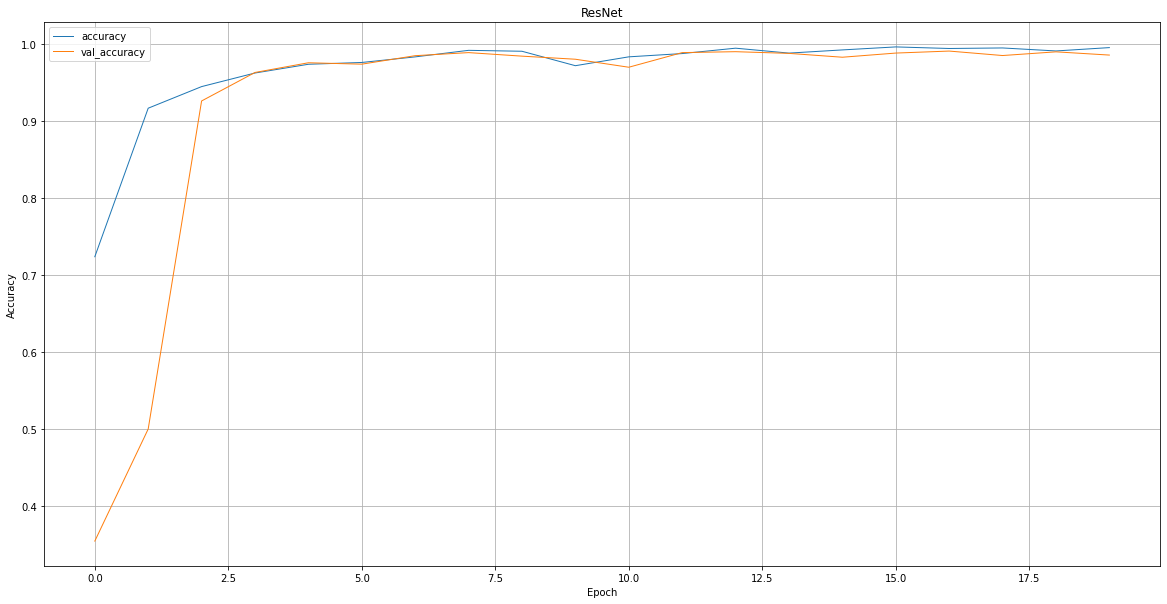

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(resNet50_model_history.history['accuracy'])
plt.plot(resNet50_model_history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet')
plt.savefig('ResNetAccuracy.png')

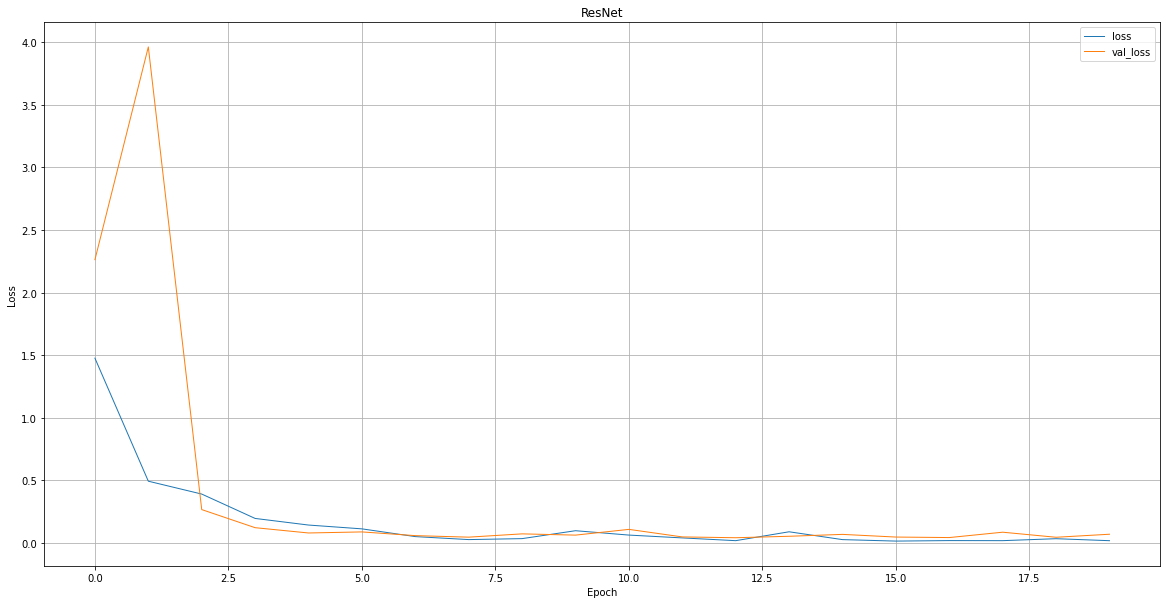

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(resNet50_model_history.history['loss'])
plt.plot(resNet50_model_history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet')
plt.savefig('ResNetLoss.png')

In [ ]:
y_true_resnet=[]
for element in test_y:
    y_true_resnet.append(np.argmax(element))
prediction_proba=resNet50_model.predict(test_x)
prediction_resnet=np.argmax(prediction_proba,axis=1)

157/157 [==============================] - 6s 19ms/step


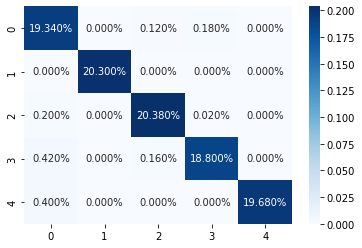

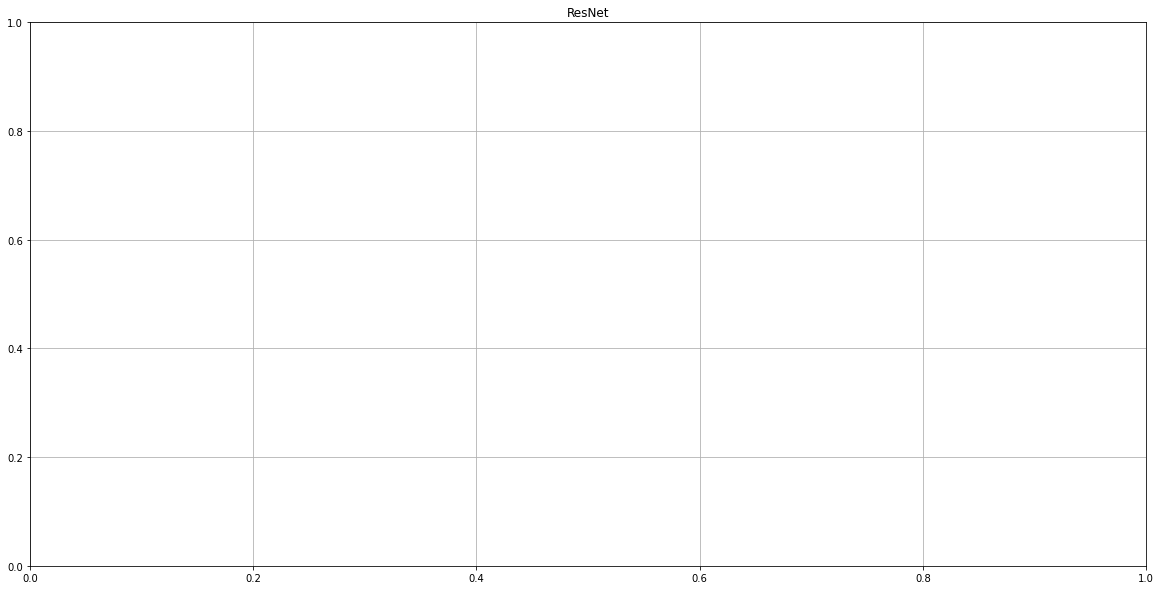

In [ ]:
resNet50_model_cf_matrix = confusion_matrix(y_true_resnet, prediction_resnet)
sns.heatmap(resNet50_model_cf_matrix/np.sum(resNet50_model_cf_matrix), annot=True,fmt='.3%', cmap='Blues')
plt.figure(figsize=(20,10))
plt.title('ResNet')
plt.savefig('ResNetConfMat.png')

In [ ]:
print('Precision: %.3f' % precision_score(y_true_resnet, prediction_resnet, average='micro'))
print('F1 Score: %.3f' % f1_score(y_true_resnet, prediction_resnet, average='micro'))
print('Recall: %.3f' % recall_score(y_true_resnet, prediction_resnet, average='micro'))
print('Accuracy: %.3f' % accuracy_score(y_true_resnet, prediction_resnet))

Precision: 0.985
F1 Score: 0.985
Recall: 0.985
Accuracy: 0.985


In [ ]:
from keras.models import load_model

resNet50_model.save('my_resnet50_model.h5')

## test prediction for a single dataline

In [ ]:
prediction = resNet50_model.predict([test_x[0:1,0:360,0]])

1/1 [==============================] - 2s 2s/step


## process and show output

In [ ]:
true_prediction=[]
for element in prediction:
    true_prediction.append(np.argmax(element))

In [ ]:
true_prediction

[1]

## create test patients

In [ ]:
# Example array
test_x = np.random.rand(2, 360, 1)

# Save the array to a CSV file
np.savetxt('test_patient_1.csv', test_x[0:1,0:360,0], delimiter=',')
np.savetxt('test_patient_2.csv', test_x[1:2,0:360,0], delimiter=',')
np.savetxt('test_patient_3.csv', train_x[2:3,0:360,0], delimiter=',')
np.savetxt('test_patient_4.csv', train_x[3:4,0:360,0], delimiter=',')
np.savetxt('test_patient_5.csv', train_x[4:5,0:360,0], delimiter=',')


In [ ]:
# Load the CSV file back into a NumPy array
loaded_array = np.genfromtxt('test_patient_4.csv', delimiter=',')

# Reshape the loaded array to match the original shape
reloaded_array = loaded_array.reshape((1, 360, 1))

In [ ]:
prediction = resNet50_model.predict(reloaded_array)

1/1 [==============================] - 0s 31ms/step
